# 23_04_27_02_DentateGyrus_速率估计

In [8]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

In [9]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

## 1. 数据读入

In [10]:
adata = scv.read("/home/huang/PyCode/scRNA/data/DentateGyrus/DentateGyrus.h5ad")
batch_key = "Age"
cluster_key = "clusters"
adata

AnnData object with n_obs × n_vars = 18213 × 27998
    obs: 'Age', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## 2. 预处理

In [11]:
batch_pair_list = None
batch_pair_list = [["P0", "P5"]]

In [12]:
knn_mask, bnn_mask, subsample_adata = velovgi.pp.preprocess(adata, sample_mode="random", batch_key=batch_key, batch_pair_list=batch_pair_list)

Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
calculating knn and bnn mask...
pair_list : [['P0', 'P5']]
smoothing...
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## 3. 默认参数执行VELOVGI并恢复可视化

In [13]:
seed_everything(seed)

In [14]:
velovgi.tl.VELOVGI.setup_anndata(adata=subsample_adata, spliced_layer="Ms", unspliced_layer="Mu")
velovgi_model = velovgi.tl.VELOVGI(subsample_adata)
# velovgi_model.train()
velovgi_model.train(max_epochs=20)

初始训练，初始化runner参数
choosing neighbor minibatch


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [03:53<00:00, 11.66s/it, loss=-3.13e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [03:53<00:00, 11.67s/it, loss=-3.13e+03, v_num=1]


In [15]:
velovgi.tl.add_velovi_outputs_to_adata(subsample_adata, velovgi_model)
subsample_adata

AnnData object with n_obs × n_vars = 9106 × 2000
    obs: 'Age', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: 'pca', 'neighbors', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_tsne', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'latent_time_velovgi', 'fit_t'
    obsp: 'distances', 'connectivities'

In [16]:
velovgi.pp.moment_layer_attribute(adata, subsample_adata, "velocity")
velovgi.pp.moment_layer_attribute(adata, subsample_adata, "velocity_u")
velovgi.pp.moment_layer_attribute(adata, subsample_adata, "fit_t")

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/24 cores)


  0%|          | 0/18213 [00:00<?, ?cells/s]

    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)
Epoch 4/500:   1%|          | 3/500 [11:11<30:52:53, 223.69s/it, loss=1.37e+04, v_num=1]


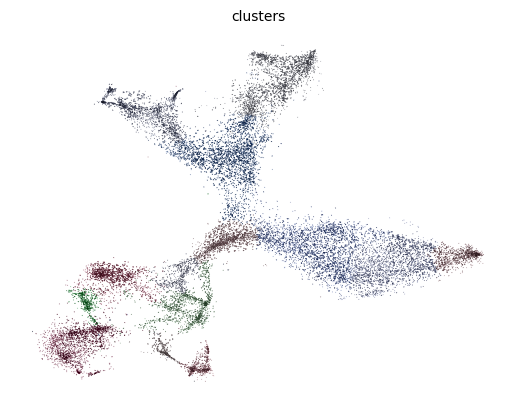

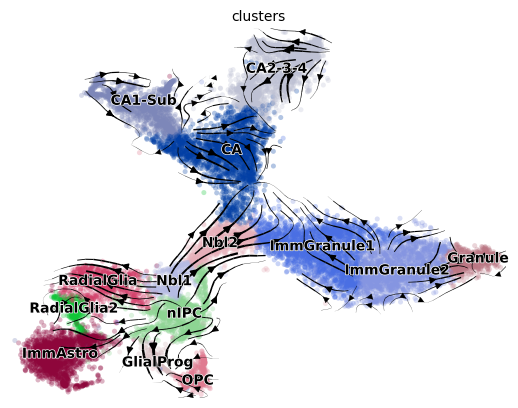

AnnData object with n_obs × n_vars = 18213 × 2000
    obs: 'Age', 'clusters', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors', 'sample_recover', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'clusters_colors'
    obsm: 'X_tsne', 'X_pca', 'velocity_tsne'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'velocity_u', 'fit_t'
    obsp: 'distances', 'connectivities'

In [17]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, color=cluster_key)
scv.pl.velocity_embedding_stream(adata, color=cluster_key)
adata

## 4. 指标计算

In [18]:
# label = cluster_key
# # 已知的细胞类型间的分化信息
# cluster_edges = [
#     ("Blood progenitors 1", "Blood progenitors 2"), 
#     ("Blood progenitors 2", "Erythroid1"), 
#     ("Erythroid1", "Erythroid2"), 
#     ("Erythroid2", "Erythroid3")
#     ]
# adata_velo = velovgi.tl.pre_metric(adata, "velocity")
# exp_metrics = velovgi.tl.summary_metric(adata_velo, cluster_edges, label, k_batch=batch_key, return_raw=True)

## 5. 结果保存

1. subsample_adata保存

In [19]:
subsample_adata.write("./tmp/DentateGyrus/subsample_adata.h5ad")

2. adata对象保存

In [20]:
adata_dir = "tmp/DentateGyrus/adata"
velovgi.tl.write_adata(adata, adata_dir)
adata = velovgi.tl.read_adata(adata_dir)

create tmp/DentateGyrus/adata
save tmp/DentateGyrus/adata/sample_recover.pkl
save tmp/DentateGyrus/adata/adata.h5ad
load tmp/DentateGyrus/adata/adata.h5ad
load tmp/DentateGyrus/adata/sample_recover.pkl


3. 模型保存

In [21]:
model_dir = "tmp/DentateGyrus/model"
velovgi_model.save(model_dir)